# Movielens Recommendation System

tensorflow core implementation** of [mriberodiaz/federatedRecsys](https://github.com/mriberodiaz/federatedRecsys/blob/master/utilsMovie.py)

In [1]:
from src.data_examples.ex2_data_loader import ExampleDataLoader

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def split_dataframe(df, frac=.8, seed=None):
  df_train = df.sample(frac=frac, random_state=seed)
  df_test = df.drop(df_train.index)
  return df_train, df_test

In [3]:
RAND_SEED = 1337

In [4]:
data_loader = ExampleDataLoader()
data_loader.download().load().clean()

using cached file cache\datasets\movielens\ml-100k.zip
extracting zip file content:
file already exists: data\ex2\ml-100k
file already exists: data\ex2\ml-100k\allbut.pl
file already exists: data\ex2\ml-100k\mku.sh
file already exists: data\ex2\ml-100k\README
file already exists: data\ex2\ml-100k\u.data
file already exists: data\ex2\ml-100k\u.genre
file already exists: data\ex2\ml-100k\u.info
file already exists: data\ex2\ml-100k\u.item
file already exists: data\ex2\ml-100k\u.occupation
file already exists: data\ex2\ml-100k\u.user
file already exists: data\ex2\ml-100k\u1.base
file already exists: data\ex2\ml-100k\u1.test
file already exists: data\ex2\ml-100k\u2.base
file already exists: data\ex2\ml-100k\u2.test
file already exists: data\ex2\ml-100k\u3.base
file already exists: data\ex2\ml-100k\u3.test
file already exists: data\ex2\ml-100k\u4.base
file already exists: data\ex2\ml-100k\u4.test
file already exists: data\ex2\ml-100k\u5.base
file already exists: data\ex2\ml-100k\u5.test
fil

c:\Python310\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Both a converter and dtype were specified for column user_id - only the converter will be used.
  return func(*args, **kwargs)
c:\Python310\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Both a converter and dtype were specified for column user_id - only the converter will be used.
  return func(*args, **kwargs)
c:\Python310\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Both a converter and dtype were specified for column movie_id - only the converter will be used.
  return func(*args, **kwargs)
c:\Python310\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Both a converter and dtype were specified for column movie_id - only the converter will be used.
  return func(*args, **kwargs)
c:\Python310\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Both a converter and dtype were specified for column release_date - only the converter will be used.

In [5]:
# the dataframe we're working with

data_loader.df

,user_id,movie_id,rating,unix_timestamp,age,sex,occupation,zip_code,title,release_date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,195,241,0.2,881250949,49,M,writer,55105,Kolya (1996),1997-01-24,...,0,0,0,0,0,0,0,0,0,0
1,304,241,0.6,886307828,23,M,programmer,94086,Kolya (1996),1997-01-24,...,0,0,0,0,0,0,0,0,0,0
2,5,241,0.4,883268170,42,M,executive,98101,Kolya (1996),1997-01-24,...,0,0,0,0,0,0,0,0,0,0
3,233,241,0.4,891033261,60,M,retired,94702,Kolya (1996),1997-01-24,...,0,0,0,0,0,0,0,0,0,0
4,62,241,0.2,875747190,31,M,marketing,75240,Kolya (1996),1997-01-24,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,862,1678,0.2,889289491,17,M,student,60089,B. Monkey (1998),1998-02-06,...,0,0,0,0,0,1,0,1,0,0
99996,862,1677,-0.2,889289570,17,M,student,60089,Mat' i syn (1997),1998-02-06,...,0,0,0,0,0,0,0,0,0,0
99997,862,1679,0.0,889289570,17,M,student,60089,Sliding Doors (1998),1998-01-01,...,0,0,0,0,0,1,0,0,0,0
99998,895,1680,0.2,887160722,28,M,writer,91505,You So Crazy (1994),1994-01-01,...,0,0,0,0,0,0,0,0,0,0


# Models

## 1. Collaborative Filtering Model

bare-bones generalized exerpt from keras-io example [collaborative filtering movielens](https://github.com/keras-team/keras-io/blob/master/examples/structured_data/ipynb/collaborative_filtering_movielens.ipynb)

In [6]:
class CollaborativeFilteringModel(tf.keras.Model):
  def __init__(self, n_U, n_V, embedding_size, **kwargs):
    super().__init__(**kwargs)
    self._num_U = n_U
    self._num_V = n_V
    self._embedding_size = embedding_size
    self._attrs = ['embedding_U', 'embedding_V', 'bias_U', 'bias_V']
    self.embedding_U = tf.keras.layers.Embedding(
      n_U,
      embedding_size,
      embeddings_initializer='he_normal',
      embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
      name='Embedding_U'
    )
    self.bias_U = tf.keras.layers.Embedding(n_U, 1, name='Embedding_bias_U')

    self.embedding_V = tf.keras.layers.Embedding(
      n_V,
      embedding_size,
      embeddings_initializer='he_normal',
      embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
      name='Embedding_V'
    )
    self.bias_V = tf.keras.layers.Embedding(n_V, 1, name='Embedding_bias_V')


  def call(self, inputs):
    vec_U = self.embedding_U(inputs[:, 0])
    bias_U = self.bias_U(inputs[:, 0])
    vec_V = self.embedding_V(inputs[:, 1])
    bias_V = self.bias_V(inputs[:, 1])

    dot_U_V = tf.tensordot(vec_U, vec_V, 2)
    x = dot_U_V + bias_U + bias_V

    return tf.nn.sigmoid(x)

  def _get_weights(self):
    ret = {}
    for attr in self._attrs:
      o = getattr(self, attr)
      if o is None:
        continue
      ret[attr] = o.get_weights()
    return ret

  def _set_weights(self, weights):
    for attr, w in weights.items():
      o = getattr(self, attr)
      if o is None:
        continue
      o.set_weights(w)

## 1.1 CF-DNN

trial implementation to cf-dnn as explained in [google.dev embedding course](https://developers.google.com/machine-learning/crash-course/embeddings/)

![EmbeddingExample3-1](./assets/EmbeddingExample3-1.svg)

In [7]:
# namespace Cf_Dnn_utils
class Cf_Dnn_utils:
  @staticmethod
  def generate_input_layers(
      data_loader,
      embedding_feature = ['user_id', 'title'],
      other_feature = ['age', 'sex', 'occupation', 'zip_code', 'rating']
    ):

    input_layers = {}

    input_layers['embedding'] = {}
    for feature in embedding_feature:
      dtype = data_loader.fetch_datatype(feature)
      input_layer = tf.keras.Input(shape=(1,), name=f'input_embedding_{feature}', dtype=dtype)
      input_layers['embedding'][feature] = {'_': input_layer}

    input_layers['other'] = {}
    for feature in other_feature:
      dtype = data_loader.fetch_datatype(feature)
      input_layer = tf.keras.Input(shape=(1,), name=f'input_{feature}', dtype=dtype)
      input_layers['other'][feature] = {'_': input_layer}

    return input_layers

In [8]:
input_layers = Cf_Dnn_utils.generate_input_layers(data_loader, embedding_feature=['movie_id'])
input_layers

{'embedding': {'movie_id': {'_': <KerasTensor: shape=(None, 1) dtype=uint64 (created by layer 'input_embedding_movie_id')>}},
 'other': {'age': {'_': <KerasTensor: shape=(None, 1) dtype=uint8 (created by layer 'input_age')>},
  'sex': {'_': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'input_sex')>},
  'occupation': {'_': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'input_occupation')>},
  'zip_code': {'_': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'input_zip_code')>},
  'rating': {'_': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'input_rating')>}}}

In [9]:
class CollaborativeFilteringDNN(tf.keras.Model):

  def __init__(self, embedding_input, embedding_vocab_size, other_inputs, embedding_dim=3, seq_dense=[4, 3]):
    raise NameError('Not implemented just yet')
    super().__init__()

    self.dense = []
    for n in seq_dense:
      self.dense.append(
        tf.keras.layers.Dense(n)
      )

  def call(self, inputs):
    pass

# Training and Evaluation

## Centralized Learning

### with bare cf model

In [10]:
# hparams
embedding_size = 50
n_epoch = 5

In [11]:
features_X = ['user_id', 'movie_id']
feature_Y = 'rating'

df_main = data_loader.df[features_X + [feature_Y]]

for feature in features_X:
  df_main.loc[:, feature] = df_main[feature].astype('int64')

df_main.loc[:, feature_Y] = df_main[feature_Y].astype('float64')


df_train, df_test = split_dataframe(df_main, seed=RAND_SEED)
df_train, df_val = split_dataframe(df_train, seed=RAND_SEED)

train_x, train_y  = df_train[features_X].values, df_train[feature_Y].values
val_x,   val_y    = df_val[features_X].values,   df_val[feature_Y].values


C:\Users\62896\AppData\Local\Temp\ipykernel_15352\2420723086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main.loc[:, feature] = df_main[feature].astype('int64')
C:\Users\62896\AppData\Local\Temp\ipykernel_15352\2420723086.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main.loc[:, feature_Y] = df_main[feature_Y].astype('float64')


In [12]:
count_users = len(data_loader.get_feature_values('user_id', tb_name='users'))
count_movies = len(data_loader.get_feature_values('movie_id', tb_name='movies'))

model = CollaborativeFilteringModel(count_users, count_movies, embedding_size)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)


In [13]:
history = model.fit(
    x=train_x,
    y=train_y,
    batch_size=64,
    epochs=n_epoch,
    verbose=1,
    validation_data=(val_x, val_y),
)


Epoch 1/5
1000/1000 [==============================] - 5s 4ms/step - loss: 0.6340 - val_loss: 0.6065
Epoch 2/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6001 - val_loss: 0.6083
Epoch 3/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5920 - val_loss: 0.6024
Epoch 4/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5883 - val_loss: 0.6010
Epoch 5/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5877 - val_loss: 0.5953


In [14]:
model.summary()

Model: "collaborative_filtering_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_U (Embedding)     multiple                  47150     
                                                                 
 Embedding_bias_U (Embedding  multiple                 943       
 )                                                               
                                                                 
 Embedding_V (Embedding)     multiple                  84100     
                                                                 
 Embedding_bias_V (Embedding  multiple                 1682      
 )                                                               
                                                                 
Total params: 133,875
Trainable params: 133,875
Non-trainable params: 0
_________________________________________________________________


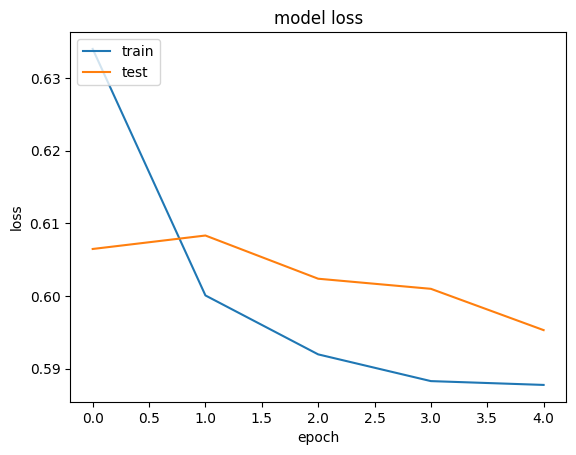

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()